In [1]:
# Erasmus+ ICCT project (2018-1-SI01-KA203-047081)

# Toggle cell visibility

from IPython.display import HTML
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.input').hide()
    } else {
        $('div.input').show()
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Toggle cell visibility <a href="javascript:code_toggle()">here</a>.''')
display(tag)

In [2]:
%matplotlib notebook
import numpy as np
import control as control
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import widgets
from ipywidgets import interact
import scipy.signal as signal
import sympy as sym


## Mehanski sistemi

#### Model mase, vzmeti in dušilke
> Model masa-vzmet-dušilka v splošnem sestoji iz ločenih vozlišč mas, razporejenih po celotnem sistemu in medsebojno povezanih z vzmetmi in dušilkami. Model se uporablja za modeliranje sistemov s kompleksnimi lastnostmi, kot sta nelinearnost in viskoelastičnost (vir: [Wikipedia](https://en.wikipedia.org/wiki/Mass-spring-damper_model "Mass-spring-model"))
#### Četrtinski model avtomobila
> Četrtinski model avtomobila se uporablja za analizo kakovosti vožnje pri uporabi različnih sistemov vzmetenja avtomobilob. Masa $m_1$ je ti. obremenjena masa, ki predstavlja eno četrtino mase avtomobila in jo podpira sistem vzmetenja. Masa $m_2$ predstavlja ti. neobremenjeno maso, tj. skupno maso kolesa in polosnega sklopa ter blažilnika z vzmetenjem. Togost in dušenje sistema za vzmetenja sta modelirana z idealno konstanto vzmeti $k_1$ in koeficientom dušenja $B$. Togost pnevmatike je modelirana s konstanto vzmeti $k_2$. (vir: [Chegg Study](https://www.chegg.com/homework-help/questions-and-answers/figure-p230-shows-1-4-car-model-used-analyze-ride-quality-automotive-suspension-systems-ma-q26244005 "1/4 car model"))

---

### Kako upravljati s tem interaktivnim primerom?

1. Preklapljaš lahko med sistemoma *masa-vzmet-dušilka* in *četritnski model avtomobila* z izbiro ustreznega gumba.
2. Za vhodno funkcijo $F$ lahko izbiraš med *koračno funkcijo*, *impulzno funkcijo*, *rampo* in *sinusno funkcijo. 
3. S premikanjem drsnikov lahko spreminjaš vrednosti mas ($m$; $m_1$ and $m_2$), koeficientov vzmeti ($k$; $k_1$ and $k_2$), koeficientov dušenja ($B$), ojačanje vstopnega signala in začetne pogoje ($x_0$, $\dot{x}_0$, $y_0$, $\dot{y}_0$).

<!-- #### General mass-spring-damper model
> The mass-spring-damper model consists of discrete mass nodes distributed throughout an object and interconnected via a network of springs and dampers. This model is well-suited for modelling object with complex material properties such as nonlinearity and viscoelasticity. (source: [Wikipedia](https://en.wikipedia.org/wiki/Mass-spring-damper_model "Mass-spring-model"))
#### 1/4 car model
> 1/4 car model is used to analyze the ride quality of automotive suspension systems. Mass $m_1$ is the "sprung mass", which is one-quarter of the vehicle mass that is supported by the suspension system. Mass $m_2$ is the "unsprung mass", which is lumped mass composed of one wheel and half-axle assembly, plus the shock absorber and suspensison springs. The stiffness and damping of the suspension system are modeled by the ideal spring constant $k_1$ and friction coefficient $B$, respecitvely. Tire stifness is modeled by spring constant $k_2$. (source: [Chegg Study](https://www.chegg.com/homework-help/questions-and-answers/figure-p230-shows-1-4-car-model-used-analyze-ride-quality-automotive-suspension-systems-ma-q26244005 "1/4 car model"))

---

### How to use this notebook?
1. Toggle between *mass-spring-damper* and *1/4 car model* system by clicking on a corresponding button.
2. Toggle betweeen *step function*, *impulse function*, *ramp function*, and *sine function* to select the function of the force $F$. 
3. Move the sliders to change the values of the mass ($m$; $m_1$ and $m_2$), spring coefficients ($k$; $k_1$ and $k_2$), damping constant ($B$), input signal amplification and initial conditions ($x_0$, $\dot{x}_0$, $y_0$, $\dot{y}_0$). -->

<table>
    <tr>
        <th style="text-align:center">Masa-vzmet-dušilka</th>
        <th style="text-align:center">Četrtinski model avtomobila</th>
    </tr>
    <tr>
        <td style="width:170px; height:150px"><img src='img/mass-spring-damper.png'></td>
        <td style="width:170px; height:150px"><img src='img/car_model.png'></td>
    </tr>
    <tr>
    </tr>    
</table>

<IPython.core.display.Javascript object>


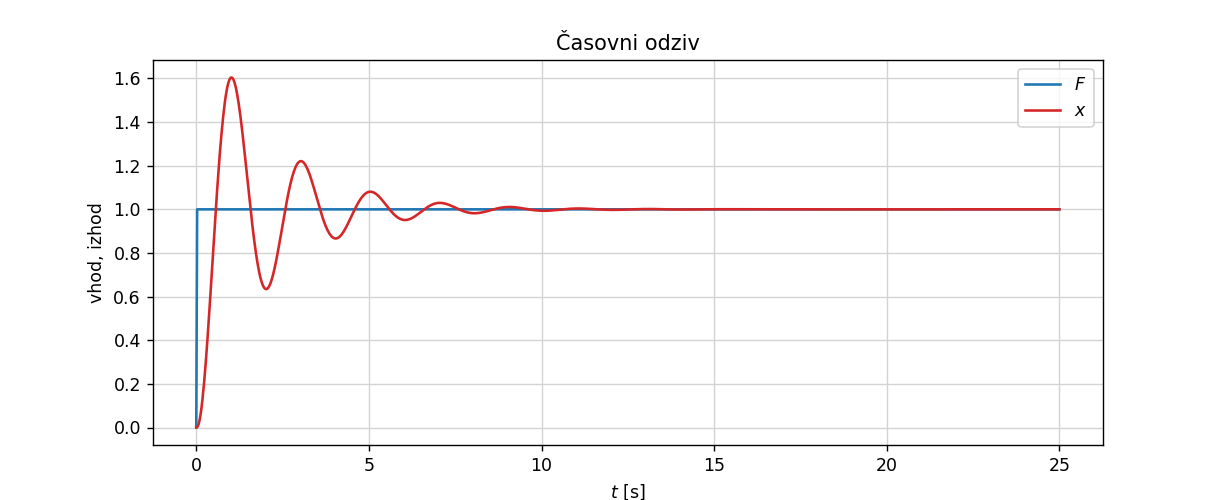

ToggleButtons(description='Izberi sistem: ', options=(('masa-vzmet-dušilka', 0), ('četrtinski model avtomobila…

ToggleButtons(description='Izberi $F$: ', options=(('koračna funkcija', 0), ('impulzna funkcija', 1), ('rampa'…

Output()

In [3]:
# create figure
fig = plt.figure(figsize=(9.8, 4),num='Mehanski sistemi')

# add sublot
ax = fig.add_subplot(111)
ax.set_title('Časovni odziv')
ax.set_ylabel('vhod, izhod')
ax.set_xlabel('$t$ [s]')

ax.grid(which='both', axis='both', color='lightgray')

inputf, = ax.plot([], [])
responsef, = ax.plot([], [])
responsef2, = ax.plot([], [])
arrowf, = ax.plot([],[])

style = {'description_width': 'initial','button_width':'180px'}

selectSystem=widgets.ToggleButtons(
    options=[('masa-vzmet-dušilka',0),('četrtinski model avtomobila',1)],
    description='Izberi sistem: ', style=style) # define toggle buttons
selectForce = widgets.ToggleButtons(
    options=[('koračna funkcija', 0), ('impulzna funkcija', 1), ('rampa', 2), ('sinusna funkcija', 3)],
    description='Izberi $F$: ', style=style)
display(selectSystem)
display(selectForce)

def build_model(M,K,B,M1,M2,B1,K1,K2,amp,x0,xpika0,y0,ypika0,select_System,index):
    
    num_of_samples = 1000
    total_time = 25
    t = np.linspace(0, total_time, num_of_samples) # time for which response is calculated (start, stop, step)
    
    global inputf, responsef, responsef2, arrowf
    
    if select_System==0:
        
        system0 = control.TransferFunction([1], [M, B, K])
        
        if index==0:
            inputfunc = np.ones(len(t))*amp
            inputfunc[0]=0
            time, response, xx = control.forced_response(system0, t, inputfunc, X0=[xpika0,x0]) 
        
        elif index==1:
            inputfunc=signal.unit_impulse(1000, 0)*amp
            time, response, xx = control.forced_response(system0, t, inputfunc, X0=[xpika0,x0]) 
    
        elif index==2:
            inputfunc=t;
            time, response, xx = control.forced_response(system0, t, inputfunc, X0=[xpika0,x0]) 
       
        elif index==3:
            inputfunc=np.sin(t)*amp
            time, response, xx = control.forced_response(system0, t, inputfunc, X0=[xpika0,x0])    
    
    elif select_System==1:
        
        system1=control.TransferFunction([M2, B1, K1+K2], [M1*M2, M1*B1+M2*B1, M2*K1+M1*(K1+K2), K2*B1, K1*K2])
        system2=control.TransferFunction([B1*K1*M2**2, B1**2*K1*M2, B1*K1**2*M2 + 2*B1*K1*K2*M2,
                                          B1**2*K1*K2, B1*K1**2*K2 + B1*K1*K2**2],
                                         [M1**2*M2**2, B1*M1**2*M2 + 2*B1*M1*M2**2, 
                                          B1**2*M1*M2 + B1**2*M2**2 + K1*M1**2*M2 + 2*K1*M1*M2**2 + 2*K2*M1**2*M2 + K2*M1*M2**2,
                                          2*B1*K1*M1*M2 + 2*B1*K1*M2**2 + B1*K2*M1**2 + 5*B1*K2*M1*M2 + B1*K2*M2**2,
                                          B1**2*K2*M1 + 2*B1**2*K2*M2 + K1**2*M1*M2 + K1**2*M2**2 + K1*K2*M1**2 + 5*K1*K2*M1*M2 + K1*K2*M2**2 + K2**2*M1**2 + 2*K2**2*M1*M2,
                                          2*B1*K1*K2*M1 + 4*B1*K1*K2*M2 + 3*B1*K2**2*M1 + 2*B1*K2**2*M2,
                                          B1**2*K2**2 + K1**2*K2*M1 + 2*K1**2*K2*M2 + 3*K1*K2**2*M1 + 2*K1*K2**2*M2 + K2**3*M1,
                                          2*B1*K1*K2**2 + B1*K2**3,
                                          K1**2*K2**2 + K1*K2**3])
        if index==0:
            inputfunc = np.ones(len(t))*amp
            inputfunc[0]=0        
            time, response, xx = control.forced_response(system1, t, inputfunc, X0=[0,0,xpika0,x0])
            time2, response2, xx2 = control.forced_response(system2, t, inputfunc, X0=[0,0,0,0,0,0,ypika0,y0])
        
        elif index==1:
            inputfunc=signal.unit_impulse(1000, 0)*amp
            time, response, xx = control.forced_response(system1, t, inputfunc, X0=[0,0,xpika0,x0])
            time2, response2, xx2 = control.forced_response(system2, t, inputfunc, X0=[0,0,0,0,0,0,ypika0,y0])
       
        elif index==2:
            inputfunc=t;
            time, response, xx = control.forced_response(system1, t, inputfunc, X0=[0,0,xpika0,x0])
            time2, response2, xx2 = control.forced_response(system2, t, inputfunc, X0=[0,0,0,0,0,0,ypika0,y0])
        
        elif index==3:
            inputfunc=np.sin(t)*amp
            time, response, xx = control.forced_response(system1, t, inputfunc, X0=[0,0,xpika0,x0])
            time2, response2, xx2 = control.forced_response(system2, t, inputfunc, X0=[0,0,0,0,0,0,ypika0,y0])

    
    ax.lines.remove(responsef)
    ax.lines.remove(inputf)
    ax.lines.remove(responsef2)
    ax.lines.remove(arrowf)
    
    inputf, = ax.plot(t,inputfunc,label='$F$',color='C0')
    responsef, = ax.plot(time, response,label='$x$',color='C3')
    
    if select_System==1:
        responsef2, = ax.plot(time, response2,label='$y$',color='C2')
    elif select_System==0:
        responsef2, = ax.plot([],[])
        
    if index==1:
        if amp>0:
            arrowf, = ax.plot([-0.1,0,0.1],[amp-((amp*0.05)/2),amp,amp-((amp*0.05)/2)],color='C0',linewidth=4)
        elif amp==0:
            arrowf, = ax.plot([],[])
        elif amp<0:
            arrowf, = ax.plot([-0.1,0,0.1],[amp-((amp*0.05)/2),amp,amp-(amp*(0.05)/2)],color='C0',linewidth=4)
    else:
        arrowf, = ax.plot([],[])
    
    ax.relim()
    ax.autoscale_view()
    
    ax.legend()    
    
def update_sliders(index):
    global m1_slider, b1_slider, k1_slider, m21_slider, m22_slider, b2_slider, k21_slider, k22_slider
    global x0_slider, xpika0_slider, y0_slider, ypika0_slider

    m1val = [0.1,0.1,0.1,0.1]
    k1val = [1,1,1,1]
    b1val = [0.1,0.1,0.1,0.1]
    m21val = [0.1,0.1,0.1,0.1]
    m22val = [0.1,0.1,0.1,0.1]
    b2val = [0.1,0.1,0.1,0.1]
    k21val = [1,1,1,1]
    k22val = [1,1,1,1]
    x0val = [0,0,0,0]
    xpika0val = [0,0,0,0]
    y0val = [0,0,0,0]
    ypika0val = [0,0,0,0]
    
    m1_slider.value = m1val[index]
    k1_slider.value = k1val[index]
    b1_slider.value = b1val[index]
    m21_slider.value = m21val[index]
    m22_slider.value = m22val[index]
    b2_slider.value = b2val[index]
    k21_slider.value = k21val[index]
    k22_slider.value = k22val[index]
    x0_slider.value = x0val[index]
    xpika0_slider.value = xpika0val[index]
    y0_slider.value = y0val[index]
    ypika0_slider.value = ypika0val[index]  
    
def draw_controllers(type_select,index):
    
    global m1_slider, b1_slider, k1_slider, m21_slider, m22_slider, b2_slider, k21_slider, k22_slider
    global x0_slider, xpika0_slider, y0_slider, ypika0_slider
   
    
    x0_slider=widgets.FloatSlider(value=0, min=-1, max=1., step=.1,
                                        description='$x_0$ [dm]:',disabled=False,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
    xpika0_slider=widgets.FloatSlider(value=0, min=-1, max=1., step=.1,
                                        description='${\dot{x}}_0$ [dm/s]:',disabled=False,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
    
    if type_select==0:
        
        amp_slider = widgets.FloatSlider(value=1.,min=-2.,max=2.,step=0.1,
            description='ojačanje vstopnega signala:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',style=style)
            
        m1_slider = widgets.FloatSlider(value=.1, min=.01, max=1., step=.01,
                                        description='$m$ [kg]:',disabled=False,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
        k1_slider = widgets.FloatSlider(value=1.,min=0.,max=20.,step=.1,
                                       description='$k$ [N/m]:',disabled=False,continuous_update=False,
                                       orientation='horizontal',readout=True,readout_format='.1f',)
        b1_slider = widgets.FloatSlider(value=.1,min=0.0,max=0.5,step=.01,
                                        description='$B$ [Ns/m]:',disabled=False,continuous_update=False,
                                        rientation='horizontal',readout=True,readout_format='.2f',)
        m21_slider = widgets.FloatSlider(value=.1,min=.01,max=1.,step=.01,
            description='$m_1$ [kg]:',disabled=True,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f',
        )
        m22_slider = widgets.FloatSlider(value=.1,min=.0,max=1.,step=.01,
            description='$m_2$ [kg]:',disabled=True,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f',
        )
        b2_slider = widgets.FloatSlider(value=.1,min=0.0,max=2,step=.01,
            description='$B$ [Ns/m]:',disabled=True,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f',
        )
        k21_slider = widgets.FloatSlider(value=1.,min=0.,max=20.,step=.1,
            description='$k_1$ [N/m]:',disabled=True,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',
        )
        k22_slider = widgets.FloatSlider(value=1.,min=0.,max=20.,step=.1,
            description='$k_2$ [N/m]:',disabled=True,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',
        )
        
        y0_slider=widgets.FloatSlider(value=0, min=-1, max=1., step=.1,
                                        description='$y_0$ [dm]:',disabled=True,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
        ypika0_slider=widgets.FloatSlider(value=0, min=-1, max=1., step=.1,
                                        description='${\dot{y}}_0$ [dm/s]:',disabled=True,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
    elif type_select==1:
        
        amp_slider = widgets.FloatSlider(value=1.,min=-2.,max=2.,step=0.1,
            description='ojačanje vstopnega signala:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',style=style)
            
        m1_slider = widgets.FloatSlider(value=.1, min=.01, max=1., step=.01,
                                        description='$m$ [kg]:',disabled=True,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
        k1_slider = widgets.FloatSlider(value=1.,min=0.,max=20.,step=.1,
                                       description='$k$ [N/m]:',disabled=True,continuous_update=False,
                                       orientation='horizontal',readout=True,readout_format='.1f',)
        b1_slider = widgets.FloatSlider(value=.1,min=0.0,max=0.5,step=.01,
                                        description='$B$ [Ns/m]:',disabled=True,continuous_update=False,
                                        rientation='horizontal',readout=True,readout_format='.2f',)
        m21_slider = widgets.FloatSlider(value=.1,min=.01,max=1.,step=.01,
            description='$m_1$ [kg]:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f',
        )
        m22_slider = widgets.FloatSlider(value=.1,min=.0,max=1.,step=.01,
            description='$m_2$ [kg]:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f',
        )
        b2_slider = widgets.FloatSlider(value=.1,min=0.0,max=2,step=.01,
            description='$B$ [Ns/m]:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.2f',
        )
        k21_slider = widgets.FloatSlider(value=1.,min=0.,max=20.,step=.1,
            description='$k_1$ [N/m]:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',
        )
        k22_slider = widgets.FloatSlider(value=1.,min=0.,max=20.,step=.1,
            description='$k_2$ [N/m]:',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.1f',
        )
        
        y0_slider=widgets.FloatSlider(value=0, min=-1, max=1., step=.1,
                                        description='$y_0$ [dm]:',disabled=False,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)
        ypika0_slider=widgets.FloatSlider(value=0, min=-1, max=1., step=.1,
                                        description='${\dot{y}}_0$ [dm/s]:',disabled=False,continuous_update=False,
                                        orientation='horizontal',readout=True,readout_format='.2f',)    
    input_data = widgets.interactive_output(build_model, {'M':m1_slider, 'K':k1_slider, 'B':b1_slider, 'M1':m21_slider,
                                                    'M2':m22_slider, 'B1':b2_slider, 'K1':k21_slider, 'K2':k22_slider, 'amp':amp_slider,
                                                    'x0':x0_slider,'xpika0':xpika0_slider,'y0':y0_slider,'ypika0':ypika0_slider,      
                                                    'select_System':selectSystem,'index':selectForce})  
    
    input_data2 = widgets.interactive_output(update_sliders, {'index':selectForce})
  
    box_layout = widgets.Layout(border='1px solid black',
                    width='auto',
                    height='',
                    flex_flow='row',
                    display='flex')

    buttons1=widgets.HBox([widgets.VBox([amp_slider],layout=widgets.Layout(width='auto')),
                         widgets.VBox([x0_slider,xpika0_slider]),
                         widgets.VBox([y0_slider,ypika0_slider])],layout=box_layout)
    display(widgets.VBox([widgets.Label('Izberi vrednosti ojačanja vstopnega signala in začetnih pogojev:'), buttons1]))
    display(widgets.HBox([widgets.VBox([m1_slider,k1_slider,b1_slider], layout=widgets.Layout(width='45%')),
                          widgets.VBox([m21_slider,m22_slider,k21_slider,k22_slider,b2_slider], layout=widgets.Layout(width='45%'))]), input_data)
    
widgets.interactive_output(draw_controllers, {'type_select':selectSystem,'index':selectForce})